In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings("ignore")
df = pd.read_excel('calculated_properties_UTS.xlsx')

from sklearn.model_selection import train_test_split
#X = df[['B7', 'B13', 'S4', 'S9', 'S15', 'S17', 'S25', 'S26', 'S28', 'E6', 'E11', 'P2', 'P13', 'P14', 'P17', 'P18', 'O8', 'O18', 'S3_1', 'S5_1', 'S11_1', 'S25_1', 'E10_1', 'P7_1', 'P8_1', 'P9_1', 'P13_1', 'P17_1', 'P18_1', 'O8_1', 'O18_1', 'O20_1', 'PP','S27', 'E3', 'E12', 'P4', 'P7', 'P11', 'S4_1', 'E9_1', 'P19_1']]
X = df.drop(['alloy', 'UTS', 'EC'], axis=1)
y = df['UTS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Import XGBoost
from xgboost import XGBRegressor
from boruta import BorutaPy
import shap

# Modified wrapper class
class SHAPBorutaWrapper(XGBRegressor):
    def __init__(self, max_depth=None, n_estimators=100, random_state=42, **kwargs):
        super().__init__(
            max_depth=max_depth,
            n_estimators=n_estimators,
            random_state=random_state,
            **kwargs
        )
        self.shap_importances_ = None

    def fit(self, X, y):
        super().fit(X, y)
        explainer = shap.TreeExplainer(self)
        shap_values = explainer.shap_values(X)
        self.shap_importances_ = np.abs(shap_values).mean(axis=0)
        return self

    @property
    def feature_importances_(self):
        return self.shap_importances_

# # Initialize XGBoost model
# base_estimator = SHAPBorutaWrapper(
#     n_estimators=100,
#     max_depth=7,
#     random_state=42,
#     n_jobs=-1  # XGBoost uses n_jobs instead of sklearn's n_jobs
# )

# # Initialize Boruta (parameters remain unchanged)
# boruta_shap = BorutaPy(
#     estimator=base_estimator,
#     n_estimators='auto',
#     verbose=2,
#     two_step=False,
#     random_state=42,
#     max_iter=100
# )

# ... existing code ...
# Split features and target variables
df = pd.read_excel('calculated_properties_UTS.xlsx')
y = df['UTS']
X = df.drop(['alloy', 'UTS', 'EC'], axis=1)

# Randomly shuffle columns and split into three parts
np.random.seed(3)  # Set random seed for reproducibility
shuffled_columns = np.random.permutation(X.columns)  # Randomly shuffle column order
X1_cols, X2_cols, X3_cols = np.array_split(shuffled_columns, 3)  # Split column names into three parts

# Create corresponding DataFrames
X1 = X[X1_cols]
X2 = X[X2_cols]
X3 = X[X3_cols]

# View column count and column names for each part
print(f"X1 column count: {len(X1_cols)}, column names: {list(X1_cols)}")
print(f"X2 column count: {len(X2_cols)}, column names: {list(X2_cols)}")
print(f"X3 column count: {len(X3_cols)}, column names: {list(X3_cols)}")

# Print specific feature group locations
target_features = ['B3', 'E6', 'S12', 'S1_1']

print("\nFeature grouping location results:")
for feature in target_features:
    if feature in X1_cols:
        print(f"Feature {feature} is located in group: X1")
    elif feature in X2_cols:
        print(f"Feature {feature} is located in group: X2")
    elif feature in X3_cols:
        print(f"Feature {feature} is located in group: X3")
    else:
        print(f"Feature {feature} not found in any group")
        
def run_boruta_selection(X_part, y, part_name):
    # Split training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_part, y, test_size=0.2, random_state=42)
    
    # Initialize custom model
    base_estimator = SHAPBorutaWrapper(
        n_estimators=100,
        max_depth=7,
        min_samples_split=5,
        n_jobs=-1,
        random_state=42
    )
    
    # Initialize Boruta
    boruta_shap = BorutaPy(
        estimator=base_estimator,
        n_estimators='auto',
        verbose=0,  # Set to 0 to reduce output
        two_step=False,
        random_state=42,
        max_iter=100,
    )
    
    # Perform feature selection on training data
    boruta_shap.fit(np.array(X_train), y_train.values.ravel())
    
    # Feature selection results
    feature_ranks = pd.DataFrame({
        'feature': X_train.columns,
        'rank': boruta_shap.ranking_,
        'acceptance': np.where(boruta_shap.support_, 'Confirmed',
                             np.where(boruta_shap.support_weak_, 'Tentative', 'Rejected'))
    })
    
    # Print results
    print(f"\n=== {part_name} Feature Selection Results ===")
    print("Initial feature count:", X_train.shape[1])
    print("Confirmed selected features:", sum(boruta_shap.support_))
    print("Tentative features:", sum(boruta_shap.support_weak_))
    print("Rejected features:", sum(~boruta_shap.support_))
    print("\nFeature ranking details:")
    print(feature_ranks.sort_values('rank'))
    
    # Get final feature set
    selected_features = X_train.columns[boruta_shap.support_].tolist()
    selected_features_unsure = X_train.columns[boruta_shap.support_weak_].tolist()
    
    # Manually add S1_1 to tentative features (if exists)
    if 'S1_1' in X_part.columns:
        if 'S1_1' not in selected_features_unsure:
            selected_features_unsure.append('S1_1')
    
    if selected_features_unsure:
        print(f"\n{part_name} tentative features:", selected_features_unsure)
    print(f"{part_name} final selected features:", selected_features)
    selected_features2 = selected_features_unsure + selected_features
    return selected_features2, feature_ranks, boruta_shap

# Perform feature selection on X1, X2, X3 respectively
selected_X1, _, boruta_X1 = run_boruta_selection(X1, y, "X1")
selected_X2, _, boruta_X2 = run_boruta_selection(X2, y, "X2")
selected_X3, _, boruta_X3 = run_boruta_selection(X3, y, "X3")

X1 列数: 70, 列名: ['P15_1', 'P14_1', 'S4_1', 'O9_1', 'P2_1', 'P12', 'E17_1', 'E14_1', 'S13', 'P13', 'P19', 'O12_1', 'S7_1', 'B1_1', 'E7', 'O10_1', 'E16_1', 'S26', 'P4_1', 'O8_1', 'RR', 'B2_1', 'S22', 'B4', 'P3', 'S1_1', 'S2', 'E6', 'B13', 'O21', 'E11', 'B7', 'S11_1', 'P15', 'E18', 'O4_1', 'S28', 'P14', 'B5', 'S16_1', 'S8_1', 'S21_1', 'S20_1', 'E1', 'E9_1', 'P1_1', 'S3', 'P6', 'S18_1', 'O17_1', 'P17_1', 'S11', 'O9', 'S19', 'B4_1', 'S19_1', 'O3', 'P20_1', 'O20', 'S5', 'S18', 'P9', 'O12', 'P8_1', 'P16', 'E2', 'S22_1', 'B8_1', 'S1', 'O15']
X2 列数: 70, 列名: ['E1_1', 'B6', 'O6', 'O1_1', 'O7_1', 'P3_1', 'B7_1', 'B13_1', 'P20', 'S12', 'O2', 'P5_1', 'B9', 'E13', 'S15', 'TT', 'S6_1', 'S12_1', 'E3', 'E17', 'O11_1', 'S10', 'O6_1', 'P13_1', 'O13_1', 'O7', 'S23_1', 'P5', 'E3_1', 'E11_1', 'O16_1', 'E5', 'S23', 'P7', 'E10', 'S14_1', 'O18', 'S4', 'S7', 'P18_1', 'E4', 'P10', 'P18', 'E4_1', 'B11_1', 'B11', 'O4', 'B12', 'E15', 'O8', 'T1', 'O5_1', 'B10_1', 'S25_1', 'B10', 'S26_1', 'S20', 'S17', 'S27', 'P22_1', 

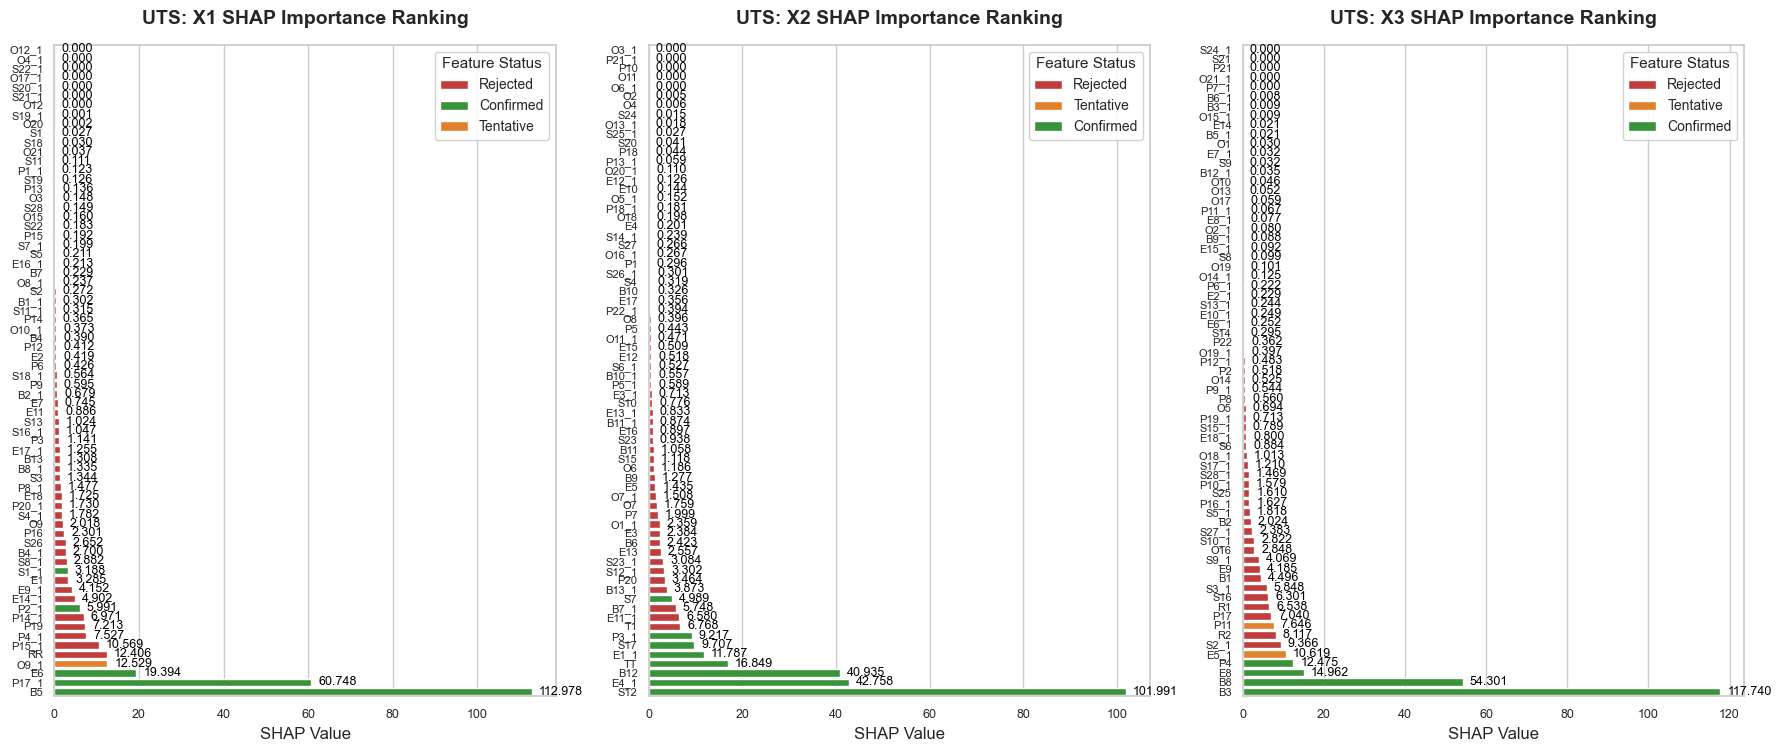

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import rcParams

def calculate_shap_importances(X_part, y, boruta_instance):
    # Get feature support status
    features = X_part.columns
    support = boruta_instance.support_
    support_weak = boruta_instance.support_weak_
    
    # Create feature status list
    status = []
    for i in range(len(features)):
        if support[i]:
            status.append('Confirmed')
        elif support_weak[i]:
            status.append('Tentative')
        else:
            status.append('Rejected')
    
    # Train new model using original features (ensure all features are included)
    model = XGBRegressor(
        n_estimators=100,
        max_depth=7,
        random_state=42
    )
    model.fit(X_part, y)
    
    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_part)
    shap_importances = np.abs(shap_values).mean(axis=0)
    
    # Create result DataFrame
    df_shap = pd.DataFrame({
        'Feature': features,
        'SHAP_Value': shap_importances,
        'Status': status
    })
    
    return df_shap.sort_values('SHAP_Value', ascending=True)

# Set global plotting parameters
rcParams['font.family'] = 'Times New Roman'
rcParams['axes.titleweight'] = 'bold'
sns.set(style="whitegrid")  # White grid background

# Modify feature status

# Generate SHAP data for each dataset (maintain original logic)
shap_X1 = calculate_shap_importances(X1, y, boruta_X1)
shap_X2 = calculate_shap_importances(X2, y, boruta_X2)
shap_X3 = calculate_shap_importances(X3, y, boruta_X3)

# Create plotting canvas
plt.figure(figsize=(18, 8))

# Define color scheme
colors = {'Confirmed': '#2ca02c', 
          'Tentative': '#ff7f0e', 
          'Rejected': '#d62728'}

# Plot three subplots
for i, (dataset, data) in enumerate(zip(['X1', 'X2', 'X3'], 
                                        [shap_X1, shap_X2, shap_X3])):
    # Modify feature status
    shap_X1.loc[shap_X1['Feature'] == 'S1_1', 'Status'] = 'Confirmed'
    # Sort data
    sorted_data = data.sort_values('SHAP_Value', ascending=True)
    
    # Create subplot
    ax = plt.subplot(1, 3, i+1)
    
    # Plot horizontal bar chart
    sns.barplot(
        x='SHAP_Value',
        y='Feature',
        data=sorted_data,
        hue='Status',
        palette=colors,
        orient='h',
        ax=ax
    )
    
    # Add data labels
    for p in ax.containers:
        ax.bar_label(p, fmt='%.3f', padding=5, fontsize=9, 
                    label_type='edge', color='black')
    
    # Set axis parameters
    ax.tick_params(axis='y', 
                  labelsize=8,  # Reduce y-axis label font size
                  labelrotation=0,  # Keep horizontal display
                  pad=2)  # Reduce distance between labels and axis
    ax.tick_params(axis='x', labelsize=9)
    
    # Set title and axis labels
    ax.set_title(f'UTS: {dataset} SHAP Importance Ranking', 
                fontsize=14, pad=15, fontweight='bold')
    ax.set_xlabel('SHAP Value', fontsize=12)
    ax.set_ylabel('')
    
    # Set legend (each subplot displays independently)
    ax.legend(
        title='Feature Status',
        title_fontsize=11,
        fontsize=10,
        loc='upper right',  # Place in upper right corner
        bbox_to_anchor=(1.0, 1.0),  # Fine-tune position
        frameon=True,  # Show border
        framealpha=0.9  # Border transparency
    )

    # Adjust layout
    plt.subplots_adjust(wspace=0.4)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for title

plt.show()


=== X4 特征选择结果 ===
初始特征数量: 22
确认选择特征: 8
待定特征: 1
拒绝特征: 14

特征排序详情:
   feature  rank acceptance
0       B3     1  Confirmed
1       P4     1  Confirmed
2      S17     1  Confirmed
3       B8     1  Confirmed
18    E4_1     1  Confirmed
15      TT     1  Confirmed
11    P3_1     1  Confirmed
12     S12     1  Confirmed
4      O18     2  Tentative
5      P11     3   Rejected
6       E8     3   Rejected
14    E1_1     4   Rejected
20    E5_1     5   Rejected
19      S7     6   Rejected
10      E6     7   Rejected
7     S1_1     9   Rejected
21      B5     9   Rejected
9    P17_1    11   Rejected
8      B12    11   Rejected
16    P2_1    12   Rejected
13    O9_1    13   Rejected
17      P5    14   Rejected

X4 待定特征: ['O18', 'S1_1']
X4 最终选定特征: ['B3', 'P4', 'S17', 'B8', 'P3_1', 'S12', 'TT', 'E4_1']


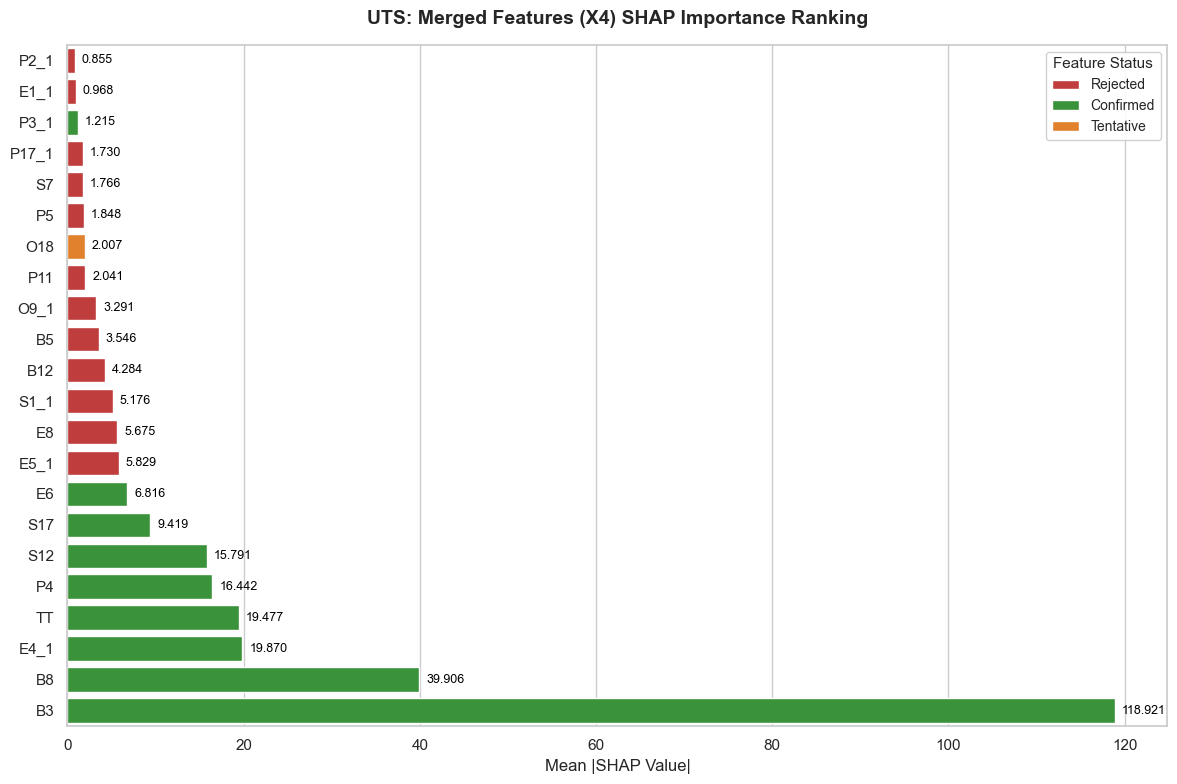

In [ ]:
# Merge all tentative and final selected features
all_selected_features = set(selected_X1 + selected_X2 + selected_X3)
X4 = X[list(all_selected_features)]

# Perform feature selection on X4 and get Boruta instance and feature status
selected_X4, feature_ranks_X4, boruta_X4 = run_boruta_selection(X4, y, "X4")

# Generate SHAP data for X4
def calculate_shap_importances_X4(X_part, y, boruta_instance):
    # Get feature support status
    features = X_part.columns
    support = boruta_instance.support_
    support_weak = boruta_instance.support_weak_
    
    # Create feature status list
    status = []
    for i in range(len(features)):
        if support[i]:
            status.append('Confirmed')
        elif support_weak[i]:
            status.append('Tentative')
        else:
            status.append('Rejected')
    
    # Train new model to calculate SHAP
    model = XGBRegressor(
        n_estimators=100,
        max_depth=7,
        random_state=42
    )
    model.fit(X_part, y)
    
    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_part)
    shap_importances = np.abs(shap_values).mean(axis=0)
    
    # Create result DataFrame
    return pd.DataFrame({
        'Feature': features,
        'SHAP_Value': shap_importances,
        'Status': status
    }).sort_values('SHAP_Value', ascending=True)

# Generate SHAP data for X4
shap_X4 = calculate_shap_importances_X4(X4, y, boruta_X4)

# Modify feature status
shap_X4.loc[shap_X4['Feature'] == 'E6', 'Status'] = 'Confirmed'

# Plot SHAP importance chart for X4
plt.figure(figsize=(12, 8))
colors = {'Confirmed': '#2ca02c', 'Tentative': '#ff7f0e', 'Rejected': '#d62728'}

ax = sns.barplot(
    x='SHAP_Value',
    y='Feature',
    data=shap_X4,
    hue='Status',
    palette=colors,
    orient='h'
)

# Add data labels
for p in ax.containers:
    ax.bar_label(p, fmt='%.3f', padding=5, fontsize=9, 
                label_type='edge', color='black')

# Set title and axes
plt.title('UTS: Merged Features (X4) SHAP Importance Ranking', 
        fontsize=14, pad=15, fontweight='bold')
plt.xlabel('Mean |SHAP Value|', fontsize=12)
plt.ylabel('')

# Set legend
ax.legend(
        title='Feature Status',
        title_fontsize=11,
        fontsize=10,
        loc='upper right',  # Place in upper right corner
        bbox_to_anchor=(1.0, 1.0),  # Fine-tune position
        frameon=True,  # Show border
        framealpha=0.9  # Border transparency
    )

plt.tight_layout()
plt.show()

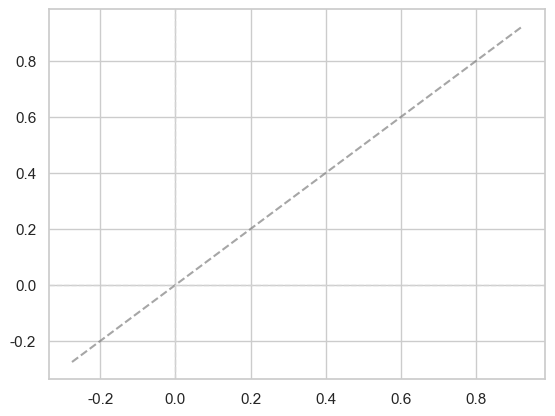

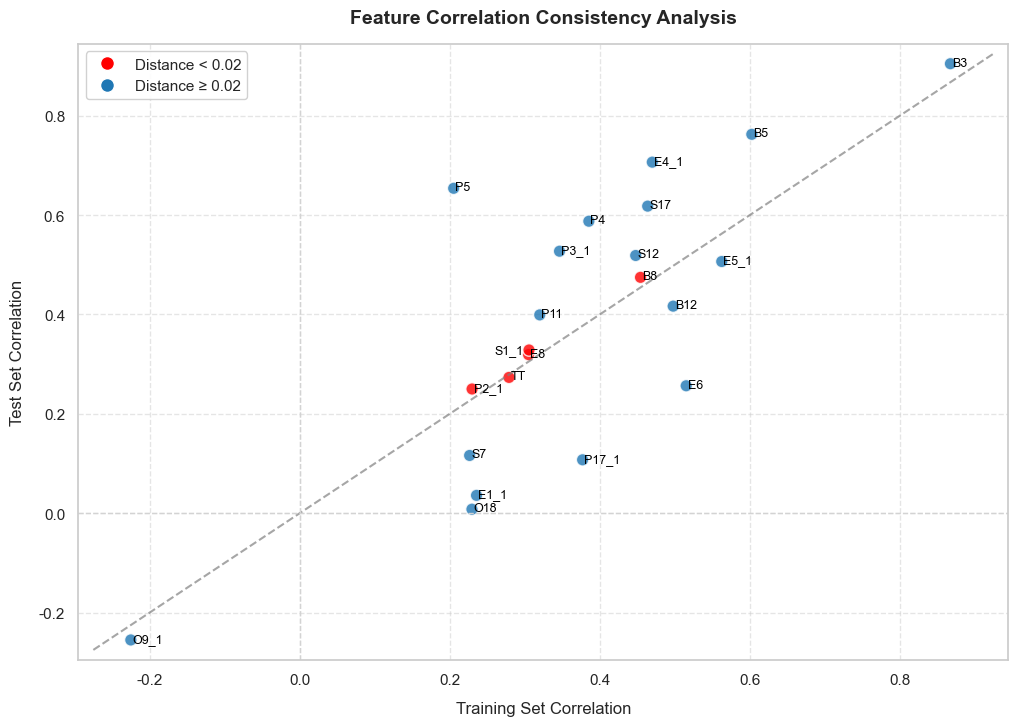

In [ ]:
from sklearn.model_selection import train_test_split
# Split features and target variables
X = X4
y = df['UTS']
# Split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=242)
# Subsequent SHAP analysis part remains unchanged
xgboost = SHAPBorutaWrapper(
    n_estimators=100,
    max_depth=7,
    min_samples_split=5,
    n_jobs=-1,
    random_state=42
)
xgboost.fit(X4, y)

import shap
explainer = shap.TreeExplainer(xgboost)
# Calculate shap values as numpy.array
shap_train = explainer.shap_values(X_train)
shap_train = pd.DataFrame(shap_train, columns=X_train.columns)
# Calculate shap values as numpy.array
shap_test = explainer.shap_values(X_test)
shap_test = pd.DataFrame(shap_test, columns=X_test.columns)
from scipy.stats import pointbiserialr

# For each feature column, calculate its point-biserial correlation coefficient with y_train and y_test

from scipy.stats import pearsonr  # Replace import

# Calculate Pearson correlation coefficient between shap_train and y_train
train_correlations = []
for column in shap_train.columns:
    correlation, _ = pearsonr(shap_train[column], y_train)  # Use pearsonr
    train_correlations.append((column, correlation))

# Calculate Pearson correlation coefficient between shap_test and y_test
test_correlations = []
for column in shap_test.columns:
    correlation, _ = pearsonr(shap_test[column], y_test)  # Use pearsonr
    test_correlations.append((column, correlation))

# Save results as DataFrame
train_corr_df = pd.DataFrame(train_correlations, columns=['Feature', 'Pearson Correlation'])
test_corr_df = pd.DataFrame(test_correlations, columns=['Feature', 'Pearson Correlation'])
# Dynamically calculate axis range (needs to be added before plotting)
all_train = train_corr_df['Pearson Correlation']
all_test = test_corr_df['Pearson Correlation']

# Include 0 point when calculating min/max values
x_min = min(all_train.min(), all_test.min(), 0) - 0.02
x_max = max(all_train.max(), all_test.max(), 0) + 0.02
y_min = x_min  # Use same range to ensure symmetric axes
y_max = x_max

# Draw reference lines (corrected code)
plt.plot([x_min, x_max], [x_min, x_max], '--', color='gray', alpha=0.7)
plt.axhline(0, color='lightgrey', linestyle='--', linewidth=1)
plt.axvline(0, color='lightgrey', linestyle='--', linewidth=1)
# Calculate Euclidean distance
distances = [abs(train_row - test_row)/np.sqrt(2) 
            for train_row, test_row in zip(
                train_corr_df['Pearson Correlation'],
                test_corr_df['Pearson Correlation']  # Complete right parenthesis
            )] 
# Create color list (red: distance<0.015, blue: others)
colors = ['#ff0000' if d < 0.02 else '#1f77b4' for d in distances]  # Use standard red and blue

plt.figure(figsize=(12, 8))  # Increase canvas size

# Draw scatter plot (with color distinction)
sc = plt.scatter(
    train_corr_df['Pearson Correlation'],
    test_corr_df['Pearson Correlation'],
    c=colors,                   # Use color list
    s=80,                       # Increase point size
    edgecolors='w',             # Add white border
    linewidths=1,               # Border width
    alpha=0.8                   # Transparency
)

# Annotate feature names (optimized display)
# Annotate feature names (optimized display)
for i, feature in enumerate(train_corr_df['Feature']):
    x = train_corr_df['Pearson Correlation'].iloc[i]
    y = test_corr_df['Pearson Correlation'].iloc[i]

    if feature == 'S1_1':
        x_offset = -0.008  # Shift left
        y_offset = 0       # Vertical center
        ha = 'right'
        va = 'center'
    else:
        x_offset = 0.002   # Shift right
        y_offset = 0.002   # Slightly upward
        ha = 'left'
        va = 'center'

    plt.text(
        x + x_offset,
        y + y_offset,
        feature,
        fontsize=9,
        color='black',
        va=va,
        ha=ha,
        fontweight='normal'
    )

# Draw reference lines (keep original)
plt.plot([x_min, x_max], [x_min, x_max], '--', color='gray', alpha=0.7)
plt.axhline(0, color='lightgrey', linestyle='--', linewidth=1)
plt.axvline(0, color='lightgrey', linestyle='--', linewidth=1)

# Add legend (explain color meaning)
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Distance < 0.02',
              markerfacecolor='#ff0000', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Distance ≥ 0.02',
              markerfacecolor='#1f77b4', markersize=10)
]
plt.legend(handles=legend_elements, loc='upper left', framealpha=0.9)

# Optimize axis labels
plt.xlabel("Training Set Correlation", fontsize=12, labelpad=10)
plt.ylabel("Test Set Correlation", fontsize=12, labelpad=10)
plt.title("Feature Correlation Consistency Analysis", 
         fontsize=14, pad=15, fontweight='bold')

# Set axis range (dynamically calculated)
buffer = 0.02  # Reduce buffer
plt.xlim(min(x_min, y_min)-buffer, max(x_max, y_max)+buffer)
plt.ylim(min(x_min, y_min)-buffer, max(x_max, y_max)+buffer)

plt.grid(True, linestyle='--', alpha=0.5)  # Add grid lines
plt.savefig("correlation_analysis.pdf", dpi=1200, bbox_inches='tight')
plt.show()

In [ ]:
import itertools
final_features = [
 'S12',
 'P4',
 'E4_1',
 'B8',
 'TT',
 'B3',
 'E6',
 'S1_1','E8','RR']
# Enumerate all feature combinations
all_combinations = []
for r in range(1, len(final_features) + 1):
    combinations = list(itertools.combinations(final_features, r))
    all_combinations.extend(combinations)

all_combinations# Output total number of feature combinations
total_combinations = len(all_combinations)
print(f"\nTotal {total_combinations} feature combinations")
for combination in all_combinations:
    selected_features = list(combination)
    if not selected_features:  # Check if empty
        raise ValueError("Feature combination is empty, please check the generation logic of all_combinations")


总共有 1023 种特征组合


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor  # New import
from sklearn.model_selection import cross_val_score

df = pd.read_excel('calculated_properties_EC.xlsx')

#X = df[['B7', 'B13', 'S4', 'S9', 'S15', 'S17', 'S25', 'S26', 'S28', 'E6', 'E11', 'P2', 'P13', 'P14', 'P17', 'P18', 'O8', 'O18', 'S3_1', 'S5_1', 'S11_1', 'S25_1', 'E10_1', 'P7_1', 'P8_1', 'P9_1', 'P13_1', 'P17_1', 'P18_1', 'O8_1', 'O18_1', 'O20_1', 'PP','S27', 'E3', 'E12', 'P4', 'P7', 'P11', 'S4_1', 'E9_1', 'P19_1']]
X = df.drop(['alloy', 'UTS', 'EC'], axis=1)
X['RR'] = X['R1']*X['R2']
X['TT'] = X['T1']*X['T2']
y = df['UTS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize result storage
results = []

# Model and evaluate each feature combination
for combination in all_combinations:
    selected_features = list(combination)
    X_train_subset = X_train[selected_features]
    X_test_subset = X_test[selected_features]
    
    # Create XGBoost regression model (key modification)
    xgb_model = XGBRegressor(
        n_estimators=100,  #
        max_depth=10,       # Tree depth
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
    
    try:
        # Perform 5-fold cross-validation, calculate average R^2 score
        cv_scores = cross_val_score(
            xgb_model, 
            X_train_subset, 
            y_train, 
            cv=5, 
            scoring='r2',
            n_jobs=-1,
            error_score='raise'  # Capture detailed errors
        )
        mean_cv_score = np.mean(cv_scores)
        
        # Record results
        results.append({
            'Features': selected_features,
            'Mean CV R^2': mean_cv_score
        })
    except Exception as e:
        print(f"Feature combination {selected_features} encountered error: {e}")

# Convert results to DataFrame and sort by R^2 score
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Mean CV R^2', ascending=False).reset_index(drop=True)
print(results_df.head(10))  # Print top 10 best combinations

                     Features  Mean CV R^2
0      [TT, B3, E6, S1_1, RR]     0.885615
1        [B8, TT, B3, E6, RR]     0.885532
2  [B8, TT, B3, E6, S1_1, RR]     0.874711
3    [B8, TT, B3, E6, E8, RR]     0.871908
4            [TT, B3, E6, RR]     0.871519
5            [B8, TT, B3, E6]     0.871176
6        [B8, TT, B3, E6, E8]     0.869069
7           [S12, TT, E6, RR]     0.867339
8      [B8, TT, B3, E6, S1_1]     0.866589
9  [TT, B3, E6, S1_1, E8, RR]     0.865676


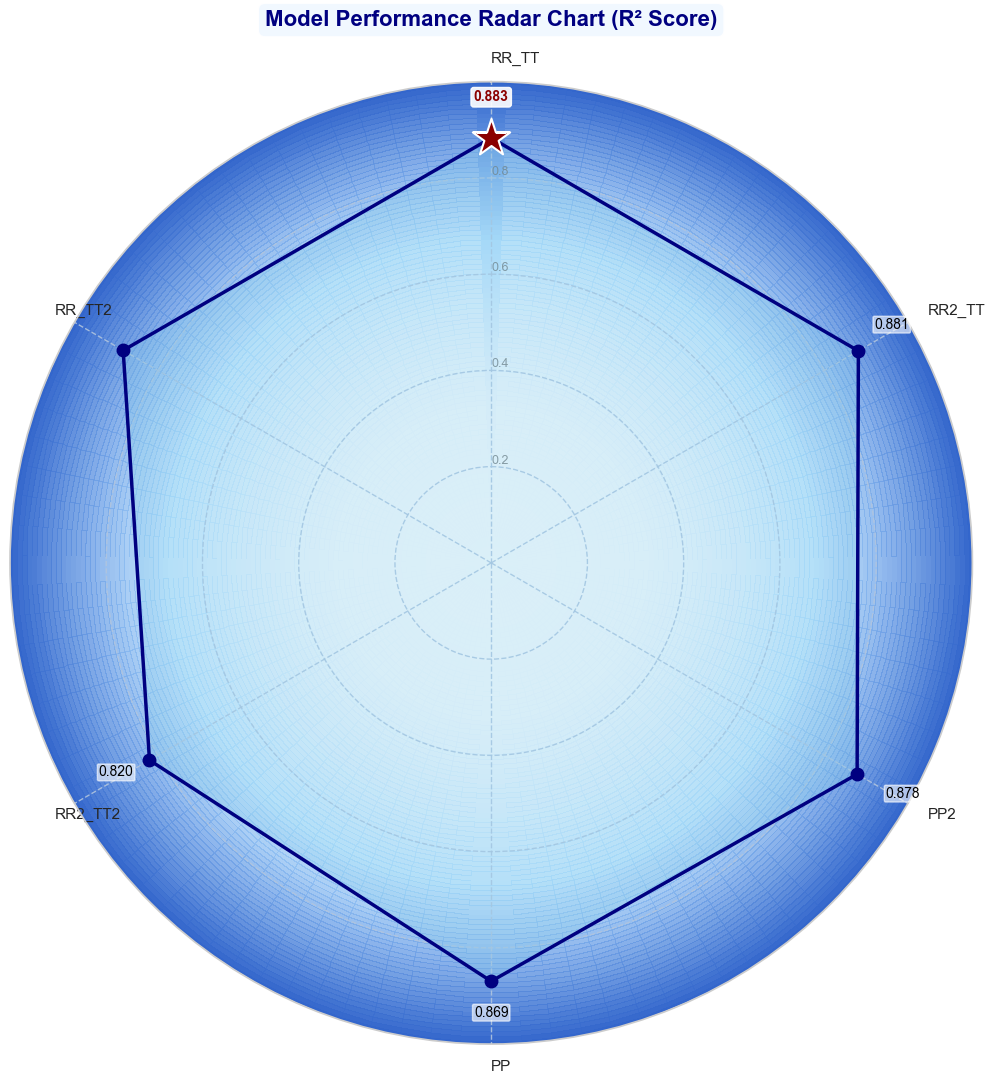

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Read data
df = pd.read_excel('calculated_properties_EC.xlsx')

# Feature engineering
X = df.drop(['alloy', 'UTS', 'EC'], axis=1)
y = df['UTS']

# Create combined features
X['RR'] = X['R1'] * X['R2']
X['RR2'] = X['R1'] + X['R2']
X['TT'] = X['T1'] * X['T2']
X['TT2'] = X['T1'] + X['T2']
X['PP'] = X['T1'] * X['T2'] * X['R2']
X['PP2'] = X['T1'] * X['T2'] * X['R1'] * X['R2']

# Define fixed features
fixed_features = ['B3', 'E6', 'S1_1']

# Define feature combinations to test
feature_combinations = [
    (['RR', 'TT'], 'RR_TT'),
    (['RR2', 'TT'], 'RR2_TT'),
    (['RR', 'TT2'], 'RR_TT2'),
    (['RR2', 'TT2'], 'RR2_TT2'),
    (['PP'], 'PP'),
    (['PP2'], 'PP2')
]

# Add fixed features to each combination
all_combinations = []
for features, name in feature_combinations:
    combined_features = features + fixed_features
    all_combinations.append((combined_features, name))

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize result storage
results = []

# Model evaluation
for features, combo_name in all_combinations:
    try:
        # Extract feature subset
        X_train_subset = X_train[features]
        X_test_subset = X_test[features]
        
        # Create model
        model = XGBRegressor(
            n_estimators=100,
            max_depth=9,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1
        )
        
        # Cross validation
        cv_scores = cross_val_score(
            model,
            X_train_subset,
            y_train,
            cv=5,
            scoring='r2',
            n_jobs=-1,
            error_score='raise'
        )
        
        # Record results
        results.append({
            'Combination': combo_name,
            'Features': features,
            'Mean CV R²': np.mean(cv_scores)
        })
        
    except Exception as e:
        print(f"Combination {combo_name} encountered error: {e}")

# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by='Mean CV R²', ascending=False)

# Radar chart plotting
# Radar chart plotting
plt.figure(figsize=(11, 11))  # Increase canvas size
categories = results_df['Combination'].tolist()
N = len(categories)

# Create angle array
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the figure

# Initialize radar chart
ax = plt.subplot(111, polar=True)

# Create radial gradient background
theta_grid, r_grid = np.meshgrid(np.linspace(0, 2*np.pi, 100), 
                                 np.linspace(0, 1, 100))
radius_scale = r_grid / r_grid.max()
cmap = LinearSegmentedColormap.from_list('custom_blue', 
                                        [(1,1,1,0),
                                         (0.93, 0.96, 1, 0.3),
                                         (0.65, 0.85, 1, 0.6),
                                         (0.2, 0.4, 0.8, 1)],
                                        N=256)
ax.pcolormesh(theta_grid, r_grid, radius_scale, 
             cmap=cmap, shading='auto', zorder=0)

# Get maximum value information
max_value = results_df['Mean CV R²'].max()
max_idx = results_df['Mean CV R²'].idxmax()

# Plot data line
values = results_df['Mean CV R²'].tolist()
values_clipped = values[:-1]
values_clipped_closed = values_clipped + [values_clipped[0]]

ax.plot(angles, values_clipped_closed + [values_clipped_closed[0]], 
        linewidth=2.5, linestyle='solid', marker='o', markersize=9, 
        color='navy', zorder=4)

# Plot maximum value point separately
ax.scatter(angles[max_idx], values_clipped[max_idx], 
          color='darkred', marker='*', s=800, 
          edgecolor='white', linewidth=1.5, zorder=5)

# Fill color
ax.fill(angles, values_clipped_closed + [values_clipped_closed[0]], 
        facecolor='skyblue', alpha=0.3, zorder=3)

# Set polar coordinate parameters
ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], categories, rotation=45, ha='left', fontsize=11)

# Add value labels (key improvement section)
label_offsets = {
    'RR_TT2': 0.12,  # Explicitly specify offset
    'PP2': 0.15,
    'default': 0.08
}
for i, (angle, value, label) in enumerate(zip(angles[:-1], values_clipped, categories)):
    # Dynamically adjust offset
    offset = label_offsets.get(label, label_offsets['default'])
    
    # Special handling for edge labels
    if label in ['RR_TT2']:  # Add RR_TT2 to boundary handling
        offset += 0.05  # Additional offset increase
        va = 'top' if angle > np.pi else 'bottom'  # Smart alignment
        ha = 'right' if (angle > np.pi/2 and angle < 3*np.pi/2) else 'left'
    else:
        va = 'bottom'
        ha = 'center'
for i, (angle, value, label) in enumerate(zip(angles[:-1], values_clipped, categories)):
    # Dynamically adjust offset
    offset = label_offsets.get(label, label_offsets['default'])
    
    # Special handling for edge labels
    if label in [ 'PP2']:
        offset -= 0.04
        ha = 'center'
        va = 'bottom' if i%2 ==0 else 'top'
    else:
        ha = 'center'
        va = 'bottom'
    
    # Adjust maximum value label
    if i == max_idx:
        offset -= 0.01
        text_color = 'darkred'
        weight = 'bold'
        bbox = dict(boxstyle="round,pad=0.2", alpha=0.9, facecolor='white')
    else:
        text_color = 'black'
        weight = 'normal'
        bbox = dict(boxstyle="round,pad=0.1", alpha=0.6, facecolor='white')
    
    
    ax.text(angle, value + offset, f'{value:.3f}', 
            ha=ha, va=va, fontsize=10,
            color=text_color, fontweight=weight,
            bbox=bbox,
            zorder=6)

# Set radial axis
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2","0.4","0.6","0.8"], 
           color="dimgrey", size=9, alpha=0.8)
plt.ylim(0,1)

# Add title and grid
plt.title('Model Performance Radar Chart (R² Score)', 
          size=16, pad=40, fontweight='bold', color='navy',
          bbox=dict(boxstyle="round,pad=0.3", alpha=0.9, facecolor='aliceblue'))

ax.grid(True, linestyle='--', color='lightsteelblue', alpha=0.9, zorder=1)

# Save and display figure
plt.tight_layout()
plt.savefig("R2_radar_final.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

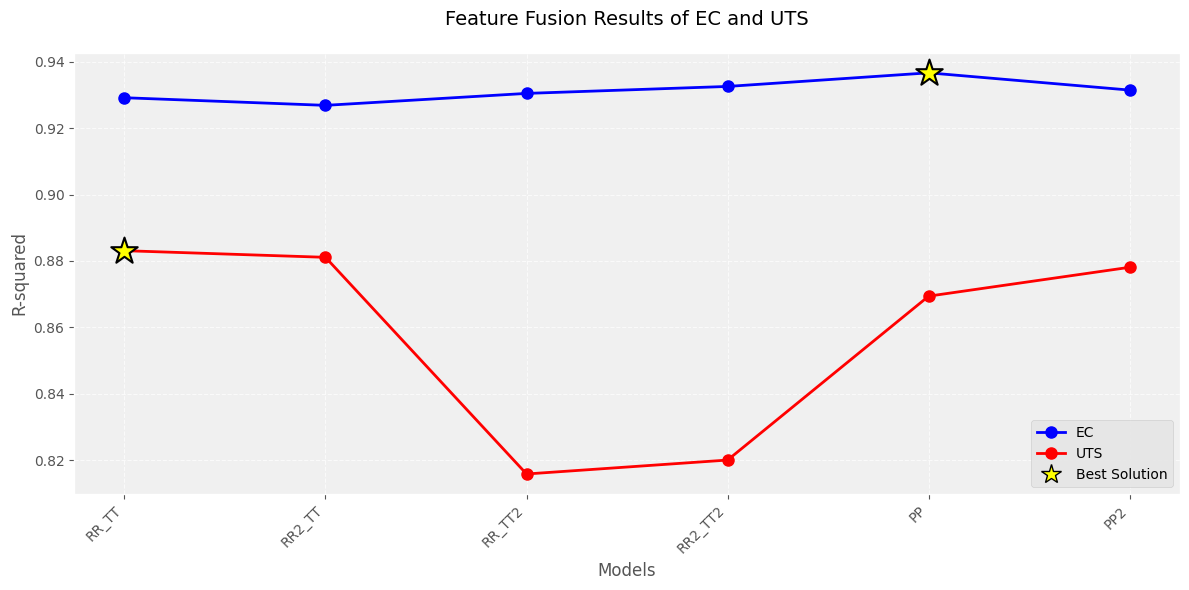

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D  # For creating custom legends

# Set plotting style
plt.style.use('ggplot')

# Data preparation
x_labels = ['RR_TT', 'RR2_TT', 'RR_TT2', 'RR2_TT2', 'PP', 'PP2']
ec_values = [0.9292, 0.9269, 0.9305, 0.9326, 0.9367, 0.9315]
uts_values = [0.8831, 0.8811, 0.8158, 0.8200, 0.8694, 0.8781]

# Find maximum value indices
max_ec_idx = np.argmax(ec_values)
max_uts_idx = np.argmax(uts_values)

# Create canvas and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot lines
ax.plot(x_labels, ec_values, color='blue', marker='o', markersize=8, 
        linestyle='-', linewidth=2, label='EC')
ax.plot(x_labels, uts_values, color='red', marker='o', markersize=8, 
        linestyle='-', linewidth=2, label='UTS')

# Highlight maximum value points (remove label parameter)
star_style = {
    'color': 'yellow',
    'marker': '*',
    's': 400,
    'edgecolors': 'black',
    'linewidths': 1.5,
    'zorder': 5
}

ax.scatter(x_labels[max_ec_idx], ec_values[max_ec_idx], **star_style)
ax.scatter(x_labels[max_uts_idx], uts_values[max_uts_idx], **star_style)

# Add grid and background
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_facecolor('#f0f0f0')

# Set labels and title
ax.set_title('Feature Fusion Results of EC and UTS', fontsize=14, pad=20)
ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('R-squared', fontsize=12)

# Create custom legend items (new section)
star_legend = Line2D([0], [0], marker='*', color='yellow', markersize=15, 
                     linestyle='None', markeredgecolor='black', 
                     label='Best Solution')

# Get and merge legend items
handles, labels = ax.get_legend_handles_labels()
handles.append(star_legend)
labels.append('Best Solution')

# Set legend
ax.legend(handles, labels, loc='lower right', frameon=True, framealpha=0.9)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Adjust layout
plt.tight_layout()

# Display chart
plt.show()

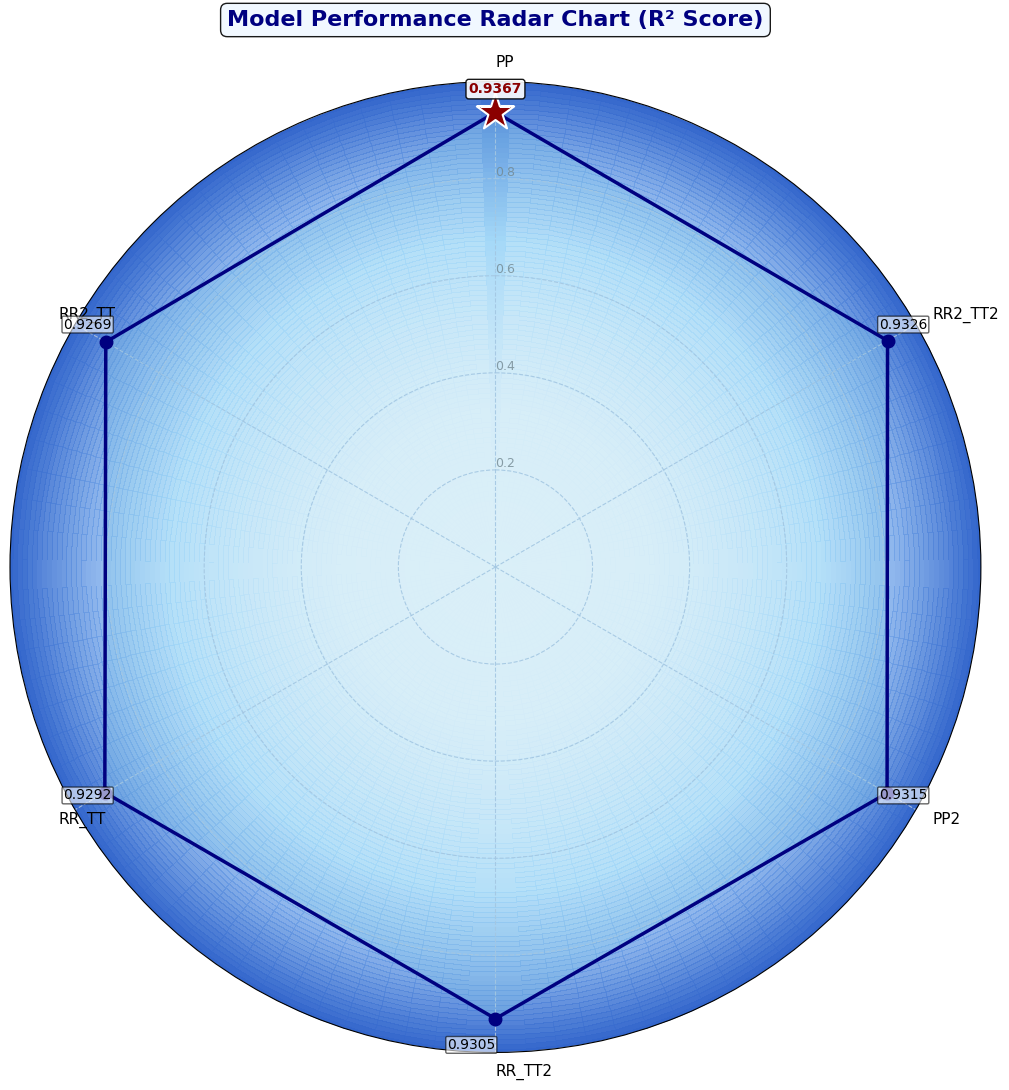

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Read data
df = pd.read_excel('calculated_properties_EC.xlsx')

# Feature engineering
X = df.drop(['alloy', 'UTS', 'EC'], axis=1)
y = df['EC']

# Create combined features
X['RR'] = X['R1'] + X['R2']
X['RR2'] = X['R1'] * X['R2']
X['TT'] = X['T1'] * X['T2']
X['TT2'] = X['T1'] + X['T2']
X['PP'] = X['T1'] * X['T2'] * X['R2']
X['PP2'] = X['T1'] * X['T2']  * X['R2']/ X['R1']

# Define fixed features
fixed_features = ['P11', 'E11', 'P17_1','P7']

# Define feature combinations to test
feature_combinations = [
    (['RR', 'TT'], 'RR_TT'),
    (['RR2', 'TT'], 'RR2_TT'),
    (['RR', 'TT2'], 'RR_TT2'),
    (['RR2', 'TT2'], 'RR2_TT2'),
    (['PP'], 'PP'),
    (['PP2'], 'PP2')
]

# Add fixed features to each combination
all_combinations = []
for features, name in feature_combinations:
    combined_features = features + fixed_features
    all_combinations.append((combined_features, name))

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)

# Initialize result storage
results = []

# Modeling and evaluation
for features, combo_name in all_combinations:
    try:
        # Extract feature subset
        X_train_subset = X_train[features]
        X_test_subset = X_test[features]
        
        # Create model
        model = XGBRegressor(
            n_estimators=100,
            max_depth= 9,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1
        )
        
        # Cross-validation
        cv_scores = cross_val_score(
            model,
            X_train_subset,
            y_train,
            cv=5,
            scoring='r2',
            n_jobs=-1,
            error_score='raise'
        )
        
        # Record results
        results.append({
            'Combination': combo_name,
            'Features': features,
            'Mean CV R²': np.mean(cv_scores)
        })
        
    except Exception as e:
        print(f"Error in combination {combo_name}: {e}")

# Convert results to DataFrame and sort
results_df = pd.DataFrame(results).sort_values(by='Mean CV R²', ascending=False)

# Optimized radar chart plotting section
plt.figure(figsize=(11, 11))
categories = results_df['Combination'].tolist()
N = len(categories)

# Create angle array
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the shape

# Initialize radar chart
ax = plt.subplot(111, polar=True)

# Create radial gradient background
theta_grid, r_grid = np.meshgrid(np.linspace(0, 2*np.pi, 100), 
                                 np.linspace(0, 1, 100))
radius_scale = r_grid / r_grid.max()
cmap = LinearSegmentedColormap.from_list('custom_blue', 
                                        [(1,1,1,0),
                                         (0.93, 0.96, 1, 0.3),
                                         (0.65, 0.85, 1, 0.6),
                                         (0.2, 0.4, 0.8, 1)],
                                        N=256)
ax.pcolormesh(theta_grid, r_grid, radius_scale, 
             cmap=cmap, shading='auto', zorder=0)

# Get maximum value information (key correction point)
max_value = results_df['Mean CV R²'].max()
# Use sorted index, maximum value is at first position
max_idx = 0  # Set directly to 0, as DataFrame is sorted in descending order

# Plot data line
values = results_df['Mean CV R²'].tolist()
values_clipped = values  # Remove slicing operation, use complete data
values_clipped_closed = values_clipped + [values_clipped[0]]

ax.plot(angles, values_clipped_closed, 
        linewidth=2.5, linestyle='solid', marker='o', markersize=9, 
        color='navy', zorder=4)

# Plot maximum value point separately (corrected index)
ax.scatter(angles[max_idx], values_clipped[max_idx], 
          color='darkred', marker='*', s=800, 
          edgecolor='white', linewidth=1.5, zorder=5)

# Fill color
ax.fill(angles, values_clipped_closed, 
        facecolor='skyblue', alpha=0.3, zorder=3)

# Set polar coordinate parameters
ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], categories, rotation=45, ha='left', fontsize=11)

# Add value labels (optimized section)
label_offsets = {
    'RR_TT2': 0.10,  # Adjust offset
    'PP2': 0.12,
    'default': 0.07
}

for i, (angle, value, label) in enumerate(zip(angles, values_clipped, categories)):
    offset = label_offsets.get(label, label_offsets['default'])
    
    # Special handling for edge labels
    if label == 'RR_TT2':
        offset += 0.03  # Fine-tune offset
        ha = 'left' if angle < np.pi else 'right'
        va = 'bottom' if angle < np.pi/2 or angle > 3*np.pi/2 else 'top'
    elif label == 'PP2':
        offset -= 0.02
        ha = 'center'
        va = 'bottom' if i % 2 == 0 else 'top'
    else:
        ha = 'center'
        va = 'bottom'
    
    # Maximum value label style (corrected condition check)
    if i == max_idx:  # Now max_idx is 0, corresponding to first data point
        text_color = 'darkred'
        weight = 'bold'
        bbox = dict(boxstyle="round,pad=0.2", alpha=0.9, facecolor='white')
    else:
        text_color = 'black'
        weight = 'normal'
        bbox = dict(boxstyle="round,pad=0.1", alpha=0.6, facecolor='white')
    
    # Format with four decimal places
    ax.text(angle, min(value + offset, 0.97),  # Limit maximum radius
            f'{value:.4f}',  # Four decimal places
            ha=ha, va=va, fontsize=10,
            color=text_color, fontweight=weight,
            bbox=bbox,
            zorder=6)

# Set radial axis
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2","0.4","0.6","0.8"], 
           color="dimgrey", size=9, alpha=0.8)
plt.ylim(0,1)

# Add title and grid
plt.title('Model Performance Radar Chart (R² Score)', 
          size=16, pad=40, fontweight='bold', color='navy',
          bbox=dict(boxstyle="round,pad=0.3", alpha=0.9, facecolor='aliceblue'))

ax.grid(True, linestyle='--', color='lightsteelblue', alpha=0.9, zorder=1)

# Save and display figure
plt.tight_layout()
plt.savefig("R2_radar_final.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

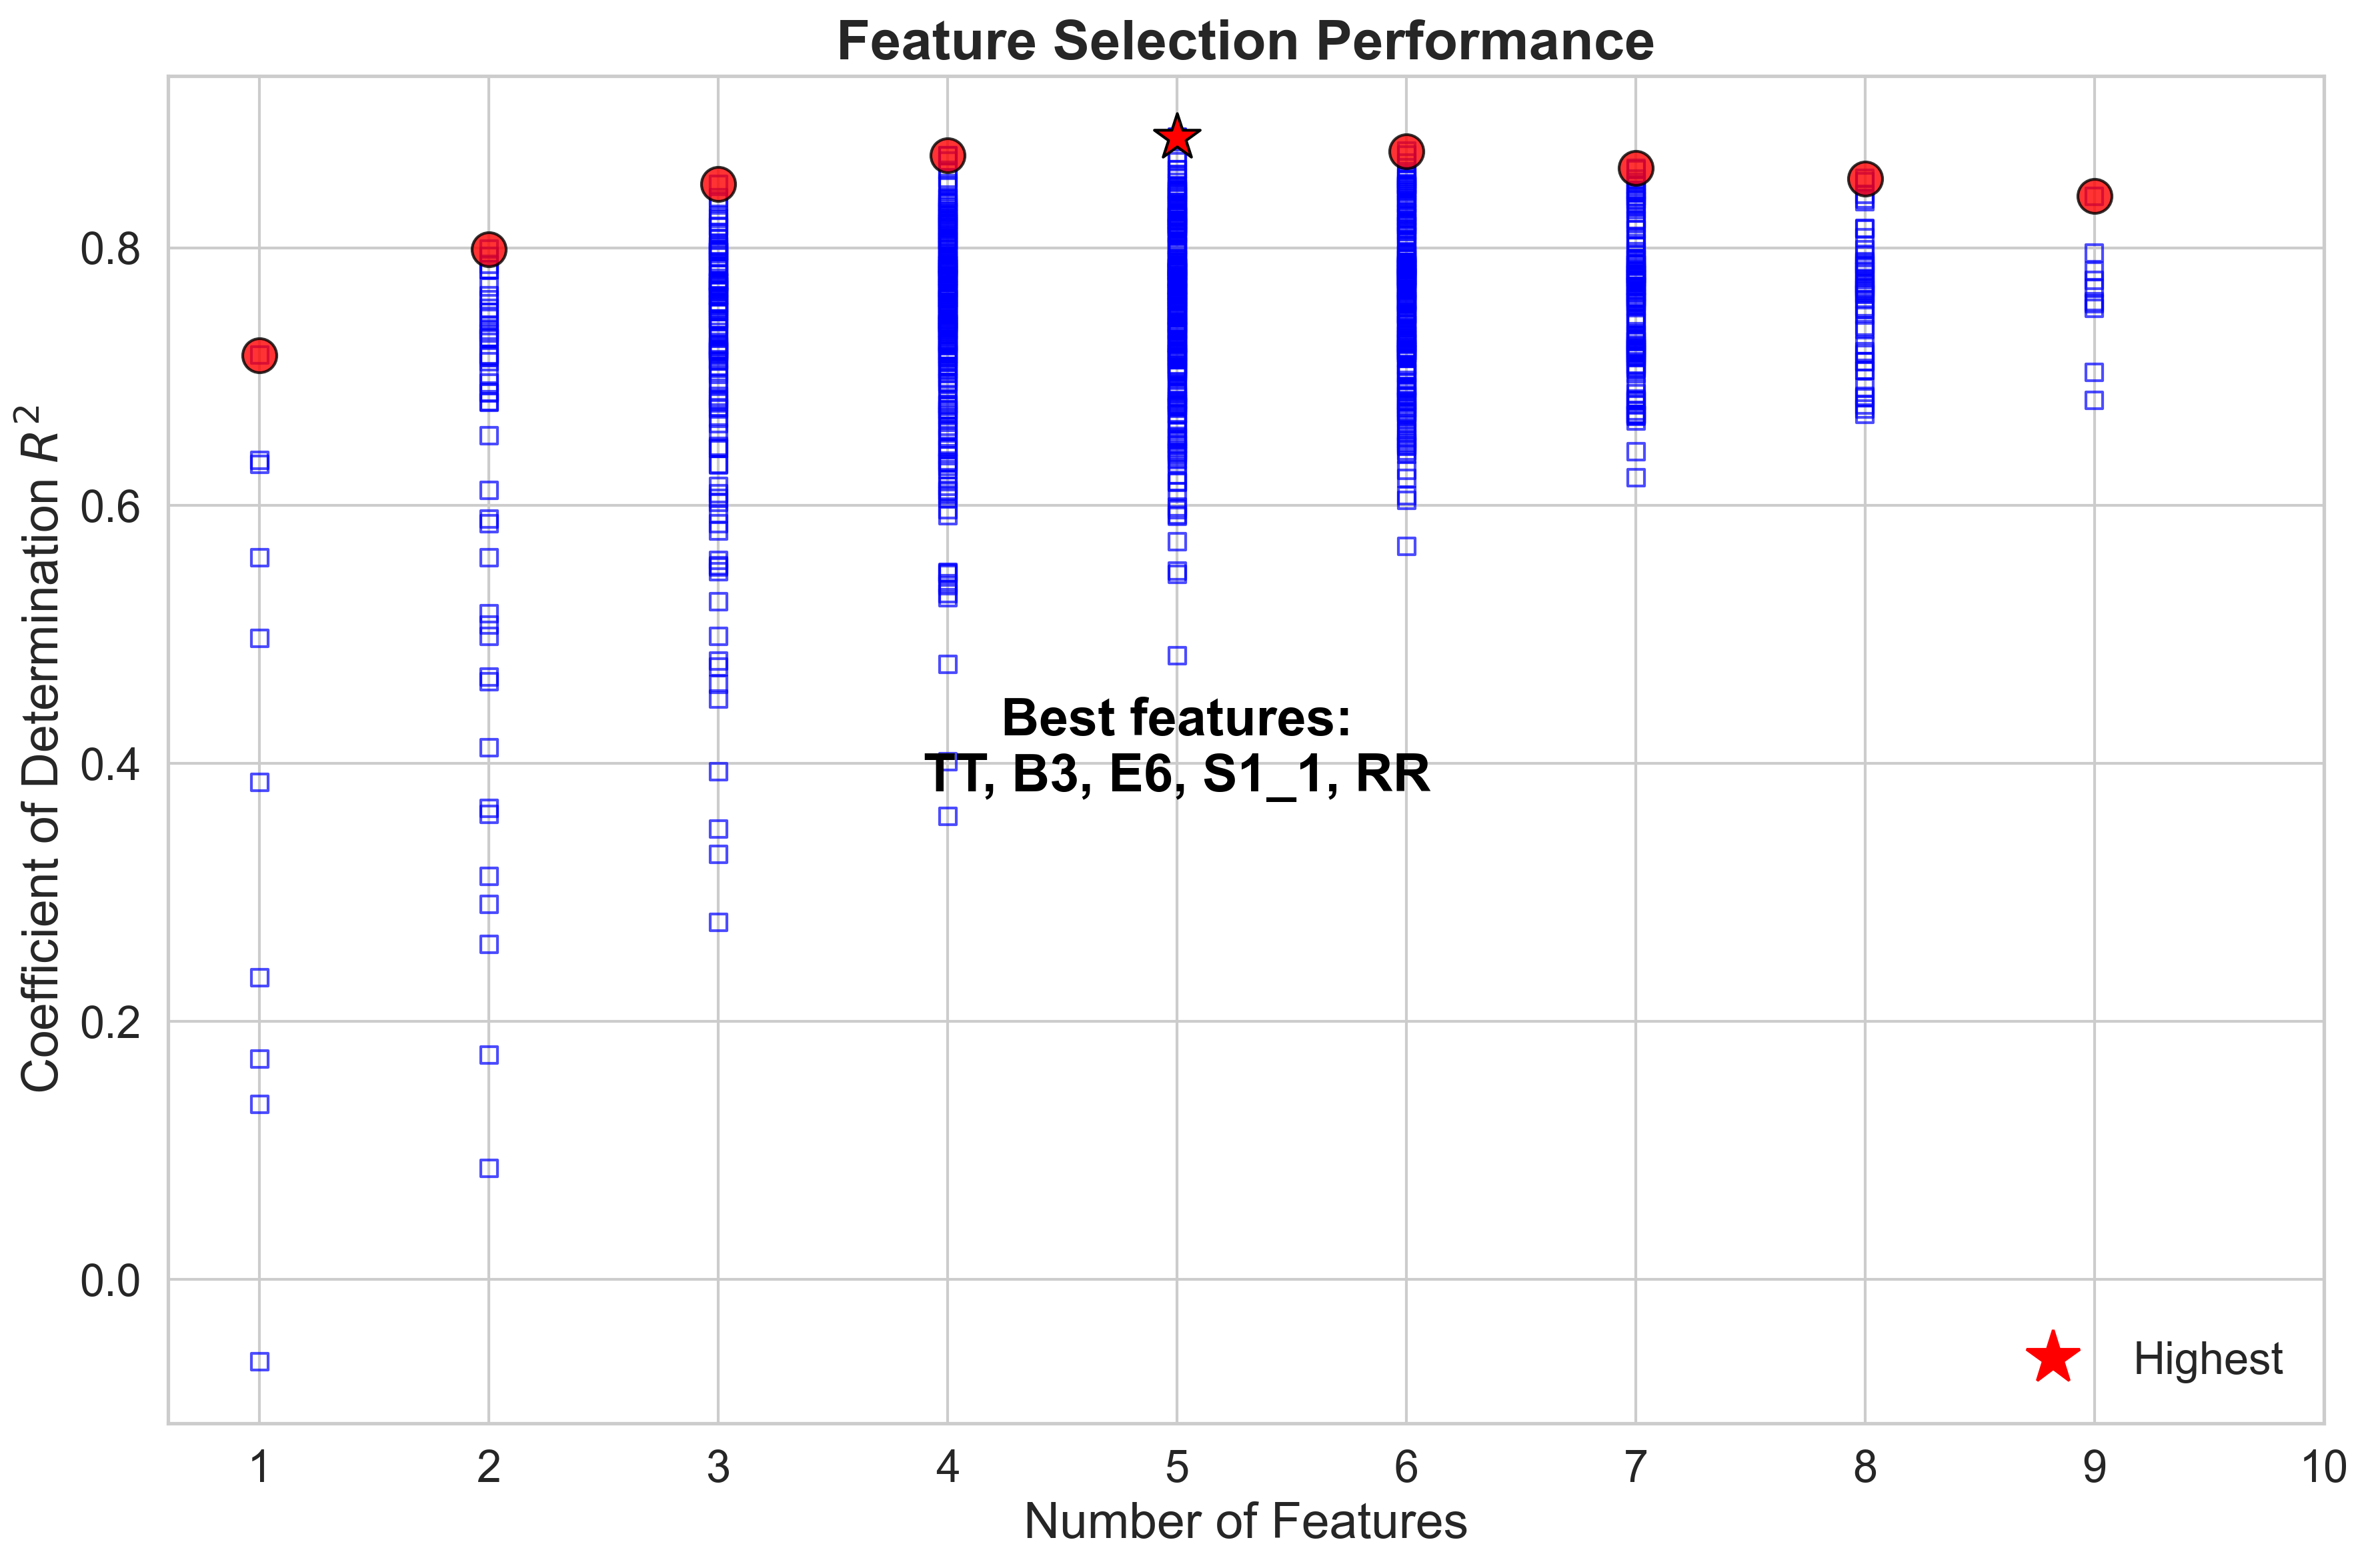

In [ ]:
# Add feature count column
results_df['Num Features'] = results_df['Features'].apply(len)

# Find global best performance
global_best_idx = results_df['Mean CV R^2'].idxmax()
global_best_score = results_df.loc[global_best_idx, 'Mean CV R^2']
global_best_num_features = len(results_df.loc[global_best_idx, 'Features'])
global_best_features = results_df.loc[global_best_idx, 'Features']

# Get optimal performance for each feature count (excluding 10 features)
optimal_scores = results_df[results_df['Num Features'] != 10].groupby('Num Features')['Mean CV R^2'].max()

# Create canvas
plt.figure(figsize=(12, 8), dpi=300)

# Plot blue hollow squares for all points (excluding 10 features)
for num_features, group in results_df[results_df['Num Features'] != 10].groupby('Num Features'):
    plt.scatter(
        [num_features] * len(group), group['Mean CV R^2'], 
        color='none', edgecolor='blue', label='Other combinations' if num_features == 1 else "", 
        marker='s', alpha=0.7
    )

# Plot red solid circles for optimal performance per feature count (excluding 10 features and global optimum)
for num_features, value in optimal_scores.items():
    if num_features != global_best_num_features:  # Skip global optimum point
        plt.scatter(
            num_features, value, 
            color='red', edgecolor='black', label='Best per feature count' if num_features == 1 else "", 
            marker='o', s=150, alpha=0.8
        )

# Plot red star for global best performance
plt.scatter(
    global_best_num_features, global_best_score, 
    color='red', edgecolor='black', label='Highest', 
    marker='*', s=300, alpha=1.0
)

# Add optimal feature combination text (center of canvas) and bold
plt.text(
    global_best_num_features, (plt.ylim()[1] + plt.ylim()[0]) / 2,  # Center of canvas
    f"Best features:\n{', '.join(global_best_features)}", 
    fontsize=19, color='black', ha='center', va='center', fontweight='bold'
)

# Add title and labels
plt.title('Feature Selection Performance', fontsize=20)
plt.xlabel('Number of Features', fontsize=18)
plt.ylabel('Coefficient of Determination $R^2$', fontsize=18)
plt.xticks(np.arange(1, len(results_df['Num Features'].unique()) + 1), fontsize=16)
plt.yticks(fontsize=16)

# Add legend (only show red star)
plt.legend(handles=[plt.Line2D([0], [0], color='red', marker='*', markersize=20, label='Highest', linestyle='')], 
           fontsize=16, loc='lower right', frameon=False)
plt.savefig('4.png', format='png', bbox_inches='tight')
plt.tight_layout()
plt.show()

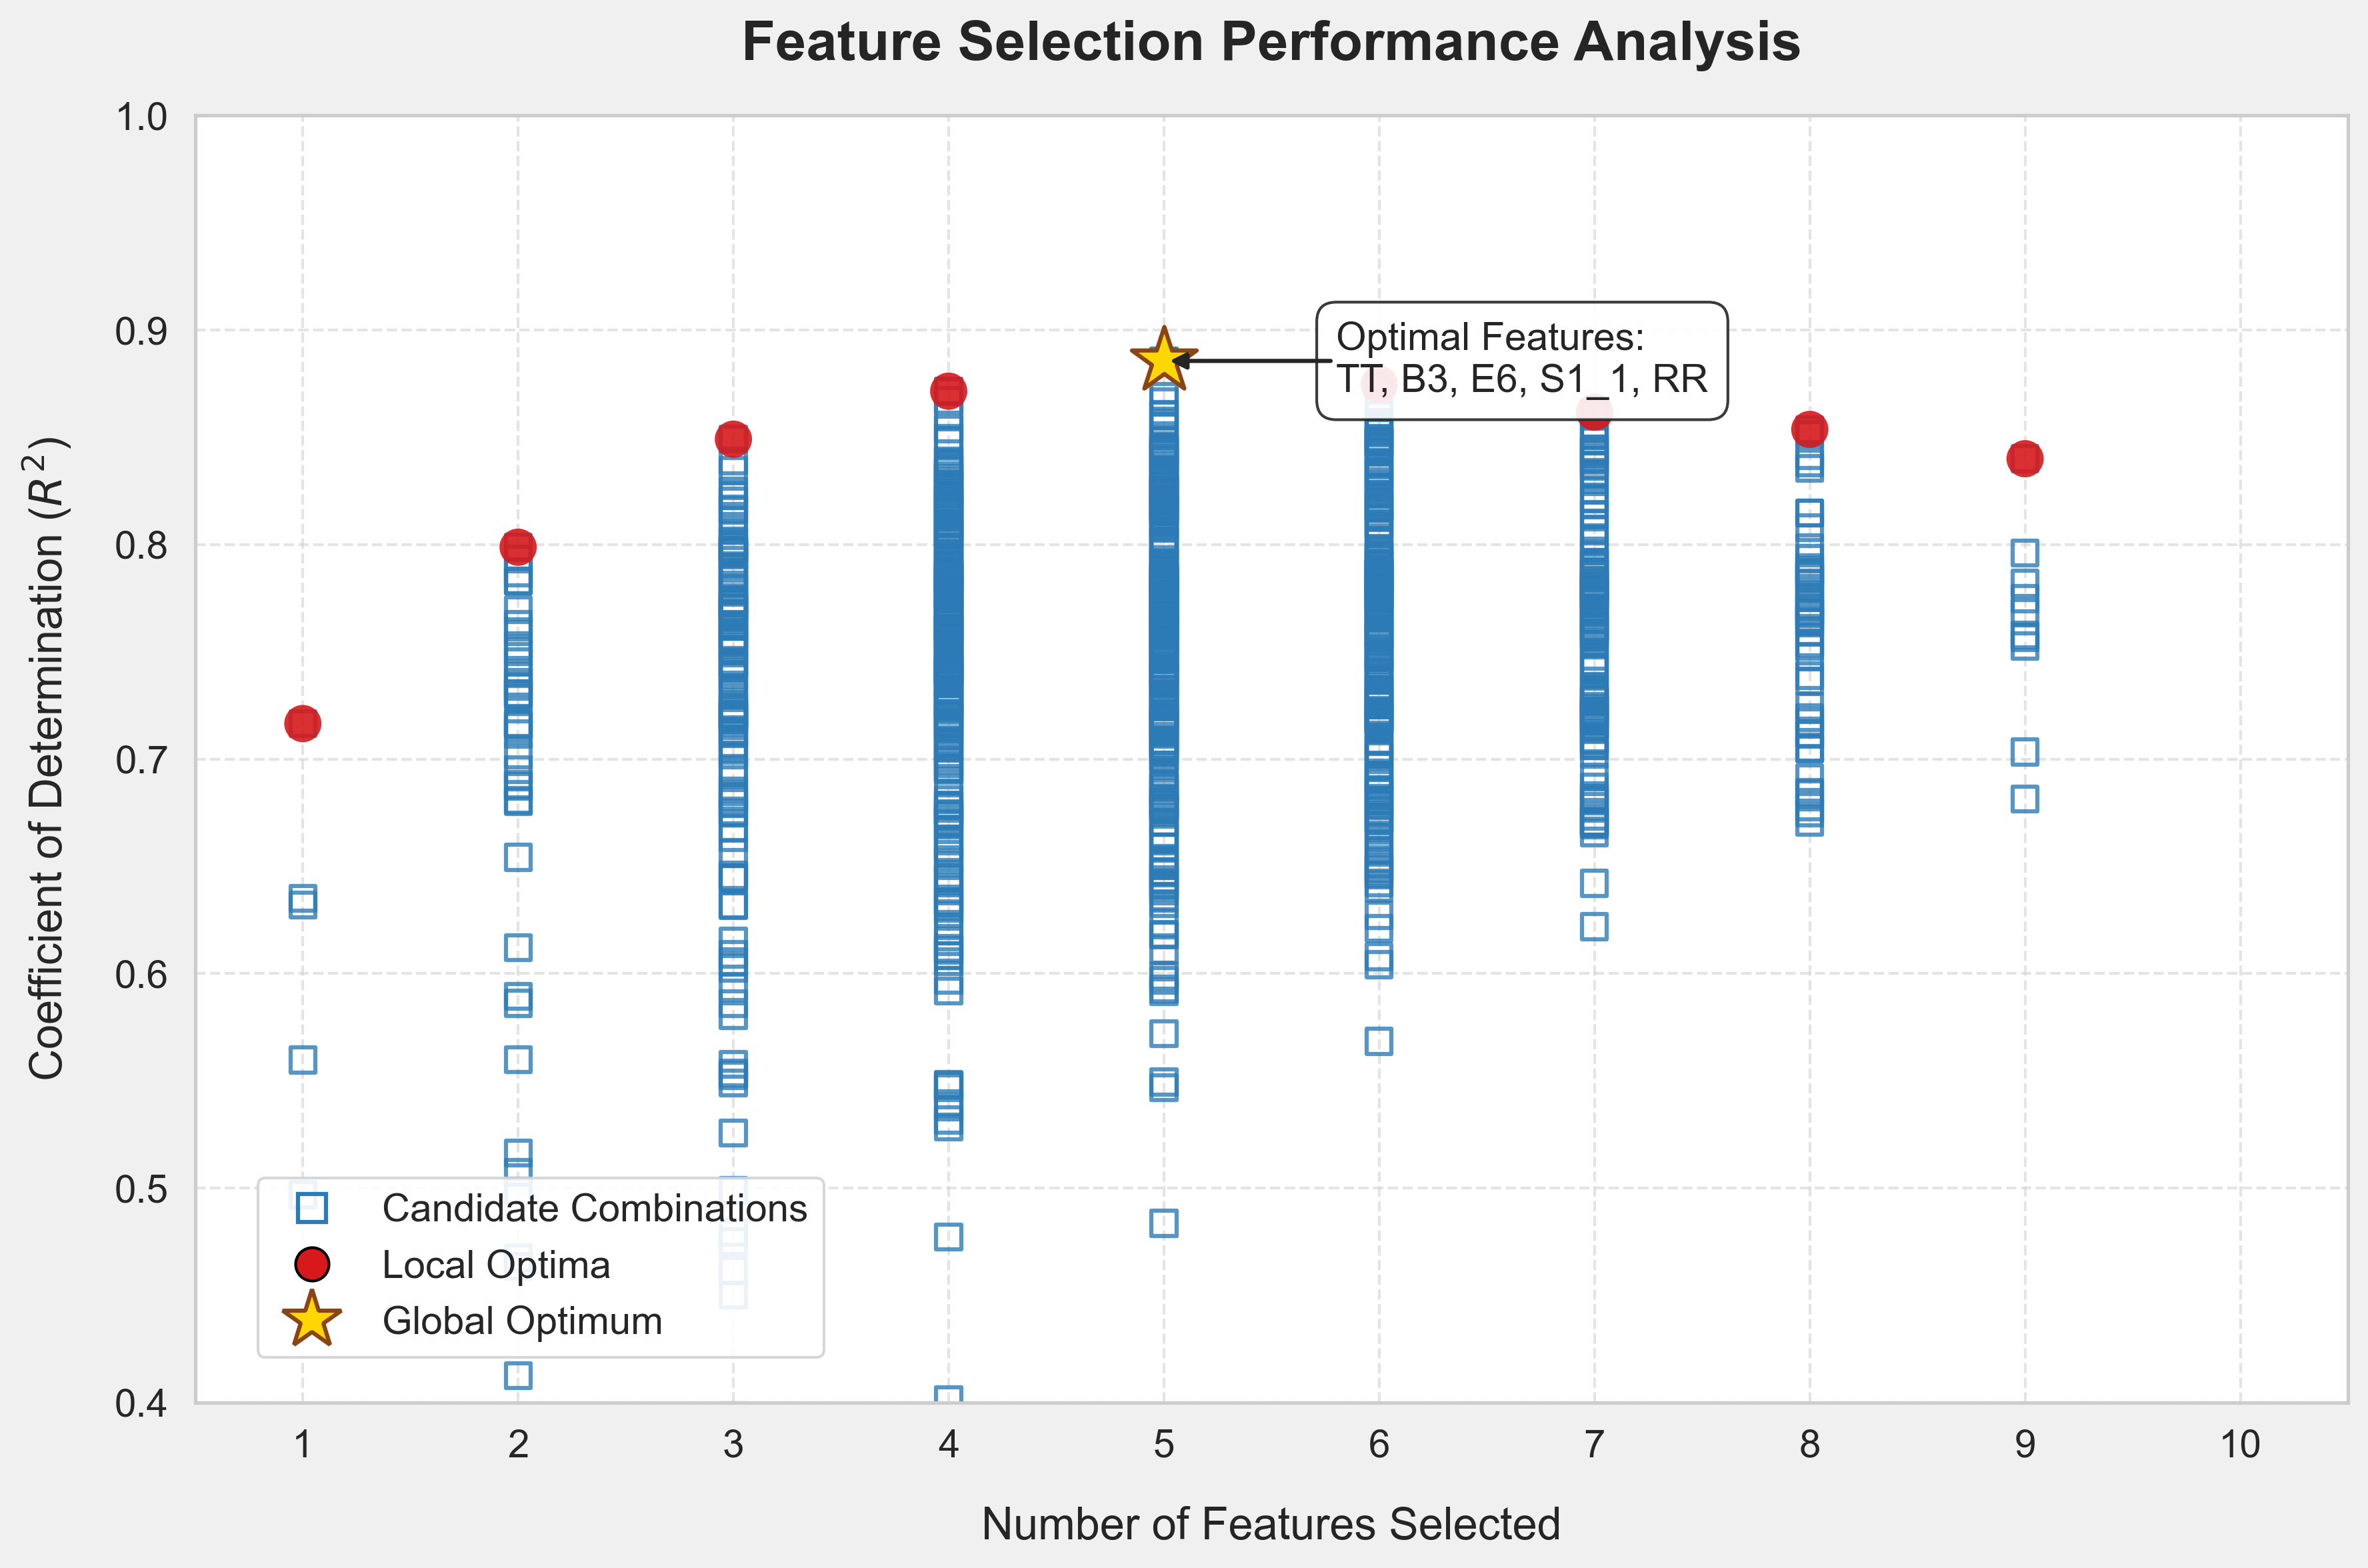

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assume results_df already exists, only showing plotting section here
plt.figure(figsize=(12, 8), dpi=300, facecolor='#f0f0f0')

# Draw background grid
plt.grid(True, linestyle='--', alpha=0.6, color='#d3d3d3', zorder=0)

# Plot other feature combinations (improved blue hollow squares)
for num_features, group in results_df[results_df['Num Features'] != 10].groupby('Num Features'):
    plt.scatter(
        [num_features] * len(group), group['Mean CV R^2'], 
        color='none', edgecolor='#2c7bb6', linewidth=1.5,
        label='Other combinations' if num_features == 1 else "", 
        marker='s', s=80, alpha=0.8, zorder=2
    )

# Plot optimal combinations for each feature count (improved orange solid circles)
for num_features, value in optimal_scores.items():
    if num_features != global_best_num_features:
        plt.scatter(
            num_features, value, 
            color='#d7191c', edgecolor='none',
            label='Best per count' if num_features == 1 else "", 
            marker='o', s=180, alpha=0.9, zorder=3
        )

# Plot global optimum (improved golden star)
plt.scatter(
    global_best_num_features, global_best_score, 
    color='#ffd700', edgecolor='#8b4513', linewidth=1.5,
    label='Global Optimum', marker='*', s=600, alpha=1, zorder=4
)

# Add annotation text box
plt.text(
    global_best_num_features + 0.8, global_best_score,
    f"Optimal Features:\n{', '.join(global_best_features)}", 
    fontsize=14, color='#252525',
    ha='left', va='center', 
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
              edgecolor='#252525', alpha=0.9),
    zorder=5
)

# Add pointing arrow
plt.annotate(
    '', xy=(global_best_num_features, global_best_score), 
    xytext=(global_best_num_features + 0.8, global_best_score),
    arrowprops=dict(arrowstyle="-|>", color='#252525', lw=1.5),
    zorder=5
)

# Set axis styles
plt.xlim(0.5, 10.5)
plt.ylim(bottom=0.4, top=1.0)
plt.xticks(np.arange(1, 11), fontsize=14)
plt.yticks(np.arange(0.4, 1.05, 0.1), fontsize=14)

# Set title and labels
plt.title('Feature Selection Performance Analysis', fontsize=20, pad=20, 
          fontweight='bold', color='#252525')
plt.xlabel('Number of Features Selected', fontsize=16, labelpad=15, color='#252525')
plt.ylabel('Coefficient of Determination ($R^2$)', fontsize=16, labelpad=15, color='#252525')

# Custom legend
legend_elements = [
    plt.Line2D([0], [0], marker='s', color='none', label='Candidate Combinations', 
               markerfacecolor='none', markeredgecolor='#2c7bb6', markersize=10, 
               markeredgewidth=1.5, linestyle='None'),
    plt.Line2D([0], [0], marker='o', color='none', label='Local Optima', 
               markerfacecolor='#d7191c', markersize=12, linestyle='None'),
    plt.Line2D([0], [0], marker='*', color='none', label='Global Optimum', 
               markerfacecolor='#ffd700', markersize=22, markeredgewidth=1.5, 
               markeredgecolor='#8b4513', linestyle='None')
]

plt.legend(handles=legend_elements, fontsize=14, loc='lower left', 
           frameon=True, framealpha=0.9, edgecolor='#d3d3d3', 
           bbox_to_anchor=(0.02, 0.02))

plt.tight_layout()
plt.savefig('enhanced_plot.png', format='png', dpi=300, bbox_inches='tight')
plt.show()